In [1]:
!pip install tabulate
!pip install --upgrade kagglehub

In [2]:
import cv2
import pickle
import warnings
import tabulate
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
from math import ceil, sqrt
from sklearn.svm import SVC
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron
from tensorflow.keras.models import Sequential
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [3]:
path = kagglehub.dataset_download("datamunge/sign-language-mnist")

100%|██████████| 62.6M/62.6M [00:00<00:00, 218MB/s]

Extracting files...


In [4]:
df_train = pd.read_csv(path + '/sign_mnist_train.csv')
df_test  = pd.read_csv(path + '/sign_mnist_test.csv')

In [5]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [6]:
df_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [7]:
mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'}

In [8]:
X_train = df_train.drop('label', axis=1)
y_train = df_train['label']

In [9]:
X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

In [10]:
pca = PCA(n_components=50)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [11]:
df_train.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [12]:
df_test.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,...,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000
mean,11.247351,147.532627,150.445761,153.324317,155.663413,158.169688,160.790853,162.282766,163.649191,165.589515,...,138.546570,145.539598,150.744980,155.638873,158.893196,159.648494,158.162019,157.672755,156.664250,154.776771
std,7.446712,43.593144,41.867838,40.442728,39.354776,37.749637,36.090916,36.212636,35.885378,33.721876,...,64.501665,65.132370,65.760539,65.565147,65.200300,65.499368,66.493576,66.009690,67.202939,68.285148
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,122.000000,126.000000,130.000000,134.000000,137.000000,141.000000,144.000000,145.000000,147.000000,...,90.000000,95.000000,99.000000,105.000000,113.000000,113.750000,113.000000,115.000000,111.000000,106.750000
50%,11.000000,154.000000,157.000000,159.000000,161.000000,163.000000,165.000000,166.000000,168.000000,169.000000,...,137.000000,155.000000,168.000000,177.000000,181.000000,182.000000,181.000000,180.000000,180.000000,179.000000
75%,18.000000,178.000000,179.000000,181.000000,182.000000,184.000000,185.000000,186.000000,187.000000,187.000000,...,195.000000,200.000000,204.250000,207.000000,207.000000,208.000000,207.000000,205.000000,206.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [13]:
df_train.isnull().values.any()

False

In [14]:
df_test.isnull().values.any()

False

In [15]:
class_distribution_train = y_train.map(mapping).value_counts()
class_distribution_train

,count
label,
R,1294
Q,1279
L,1241
W,1225
F,1204
S,1199
O,1196
D,1196
T,1186


In [16]:
class_distribution_test = y_test.map(mapping).value_counts()
class_distribution_test

,count
label,
E,498
H,436
B,432
M,394
G,348
P,347
V,346
Y,332
K,331


In [17]:
def showDistribution(data, title=None):

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    if title:
        fig.suptitle(title, fontsize=16)

    sns.barplot(x=data.index, y=data.values, palette='viridis', ax=ax[0])
    ax[0].set_title('Class Distribution (Bar Plot)')
    ax[0].set_xlabel('Label')
    ax[0].set_ylabel('Number of Images')
    ax[0].tick_params(axis='x', rotation=60)

    ax[1].pie(data.values, labels=data.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', len(data)))
    ax[1].set_title('Class Distribution (Pie Chart)')

    plt.tight_layout()
    plt.show()

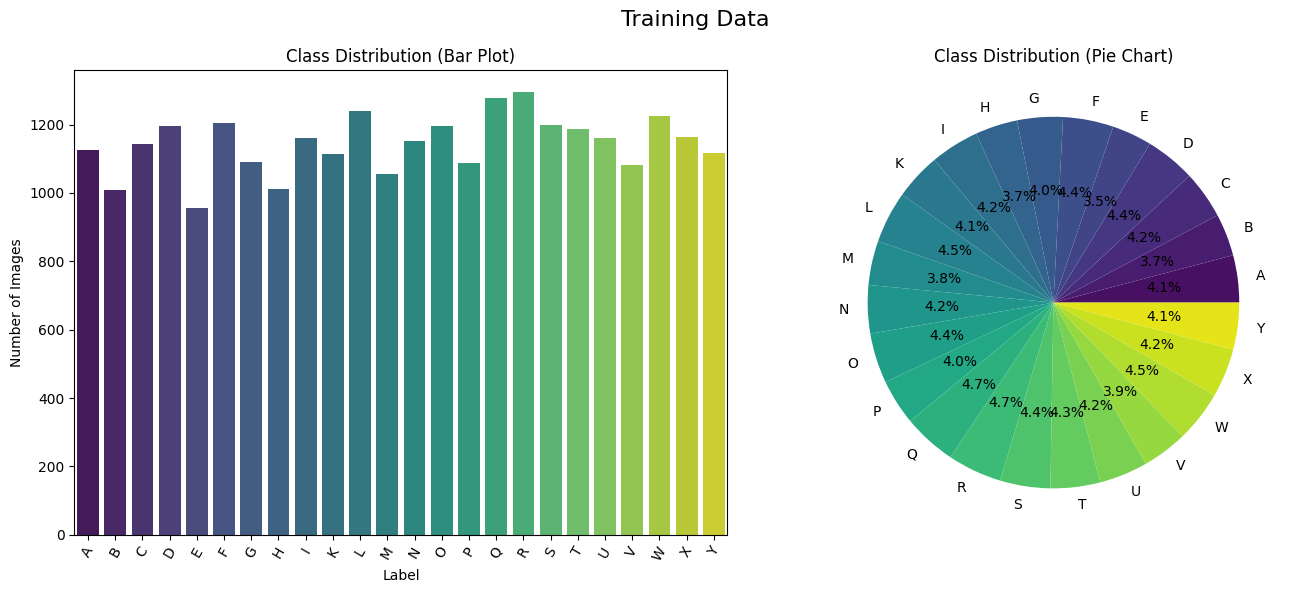

In [18]:
showDistribution(class_distribution_train.sort_index(), 'Training Data')

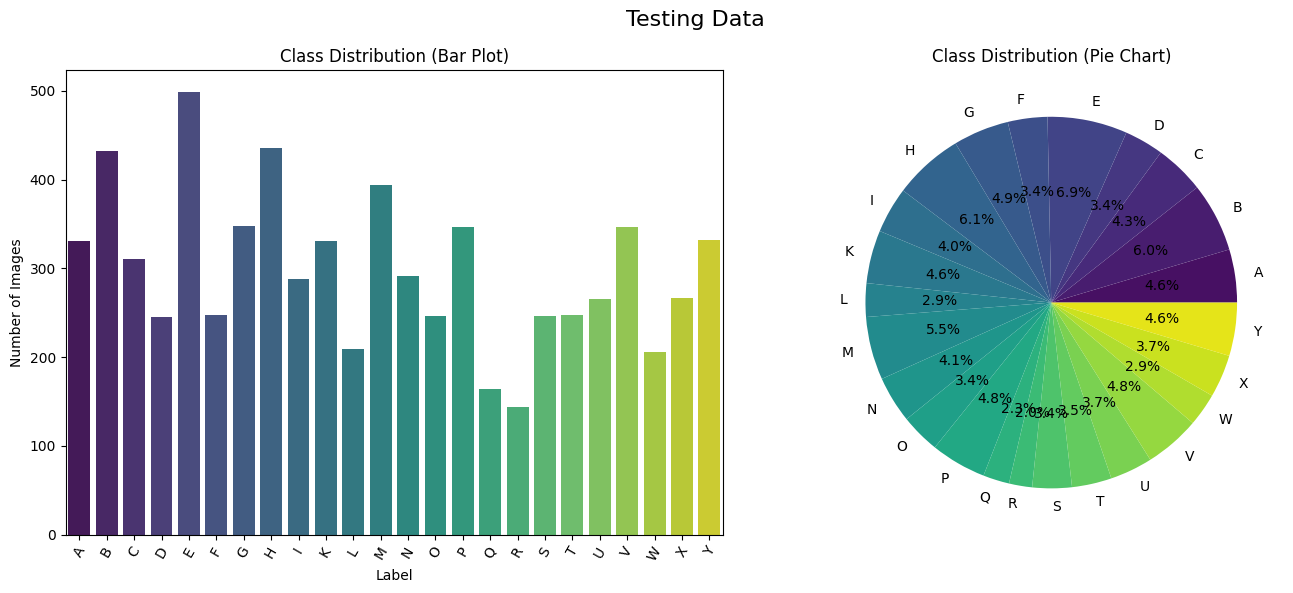

In [19]:
showDistribution(class_distribution_test.sort_index(), 'Testing Data')

In [20]:
print("Average number of Images per Class in Training Data: ", round(class_distribution_train.mean(), 2))
print("Average number of Images per Class in Testing  Data: ", round(class_distribution_test. mean(), 2))

Average number of Images per Class in Training Data:  1143.96
Average number of Images per Class in Testing  Data:  298.83


In [21]:
def check_class_imbalance(distr):

    table_data = [[label, count, f"{(distr / distr.max())[label]:.4f}"] for label, count in distr.items()]

    print(tabulate.tabulate(table_data, headers=["Class", "Count", "Ratio"], tablefmt="grid"))

In [22]:
check_class_imbalance(class_distribution_train)

+---------+---------+---------+
| Class   |   Count |   Ratio |
+=========+=========+=========+
| R       |    1294 |  1      |
+---------+---------+---------+
| Q       |    1279 |  0.9884 |
+---------+---------+---------+
| L       |    1241 |  0.959  |
+---------+---------+---------+
| W       |    1225 |  0.9467 |
+---------+---------+---------+
| F       |    1204 |  0.9304 |
+---------+---------+---------+
| S       |    1199 |  0.9266 |
+---------+---------+---------+
| O       |    1196 |  0.9243 |
+---------+---------+---------+
| D       |    1196 |  0.9243 |
+---------+---------+---------+
| T       |    1186 |  0.9165 |
+---------+---------+---------+
| X       |    1164 |  0.8995 |
+---------+---------+---------+
| I       |    1162 |  0.898  |
+---------+---------+---------+
| U       |    1161 |  0.8972 |
+---------+---------+---------+
| N       |    1151 |  0.8895 |
+---------+---------+---------+
| C       |    1144 |  0.8841 |
+---------+---------+---------+
| A     

In [23]:
check_class_imbalance(class_distribution_test)

+---------+---------+---------+
| Class   |   Count |   Ratio |
+=========+=========+=========+
| E       |     498 |  1      |
+---------+---------+---------+
| H       |     436 |  0.8755 |
+---------+---------+---------+
| B       |     432 |  0.8675 |
+---------+---------+---------+
| M       |     394 |  0.7912 |
+---------+---------+---------+
| G       |     348 |  0.6988 |
+---------+---------+---------+
| P       |     347 |  0.6968 |
+---------+---------+---------+
| V       |     346 |  0.6948 |
+---------+---------+---------+
| Y       |     332 |  0.6667 |
+---------+---------+---------+
| K       |     331 |  0.6647 |
+---------+---------+---------+
| A       |     331 |  0.6647 |
+---------+---------+---------+
| C       |     310 |  0.6225 |
+---------+---------+---------+
| N       |     291 |  0.5843 |
+---------+---------+---------+
| I       |     288 |  0.5783 |
+---------+---------+---------+
| X       |     267 |  0.5361 |
+---------+---------+---------+
| U     

In [24]:
def displaySampleImages(df, title=None):

    fig, ax = plt.subplots(6, 4, figsize=(12, 15))

    if title:
        fig.suptitle(title, fontsize=16)

    for i, label in enumerate(sorted(mapping.keys())):
        ax[i // 4, i % 4].imshow(df[df['label'] == label].iloc[0, 1:].values.reshape(28, 28), cmap='gray')
        ax[i // 4, i % 4].set_title(f"Class: {mapping.get(label)}")
        ax[i // 4, i % 4].axis('off')

    plt.tight_layout()
    plt.show()

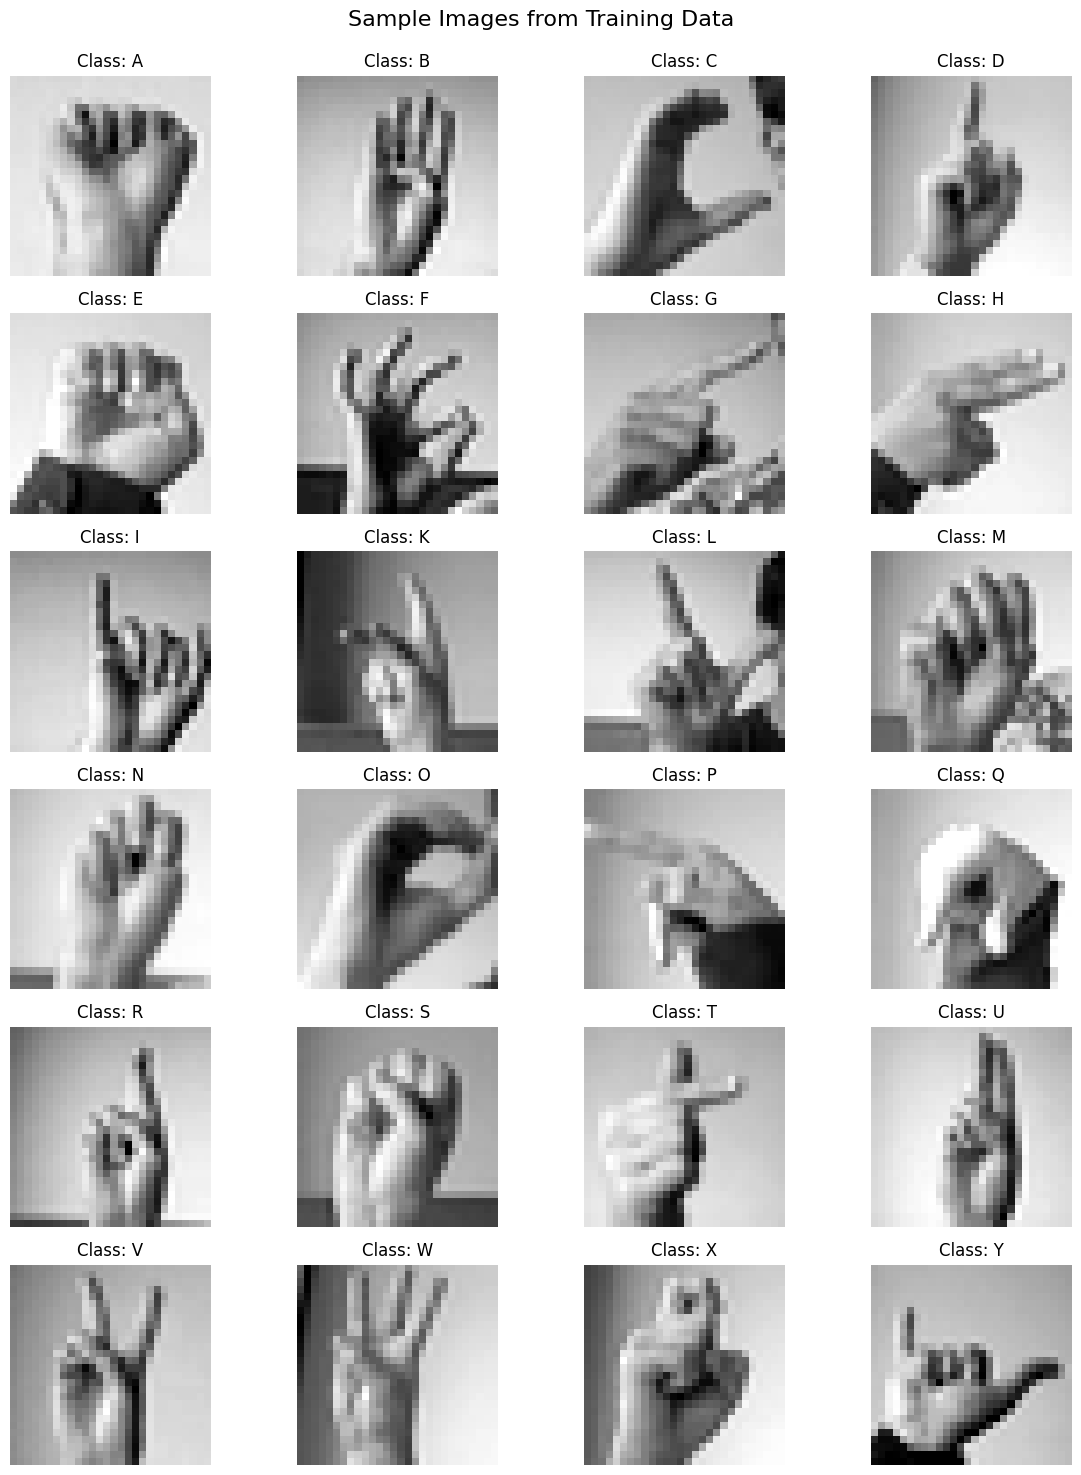

In [25]:
displaySampleImages(df_train, 'Sample Images from Training Data\n')

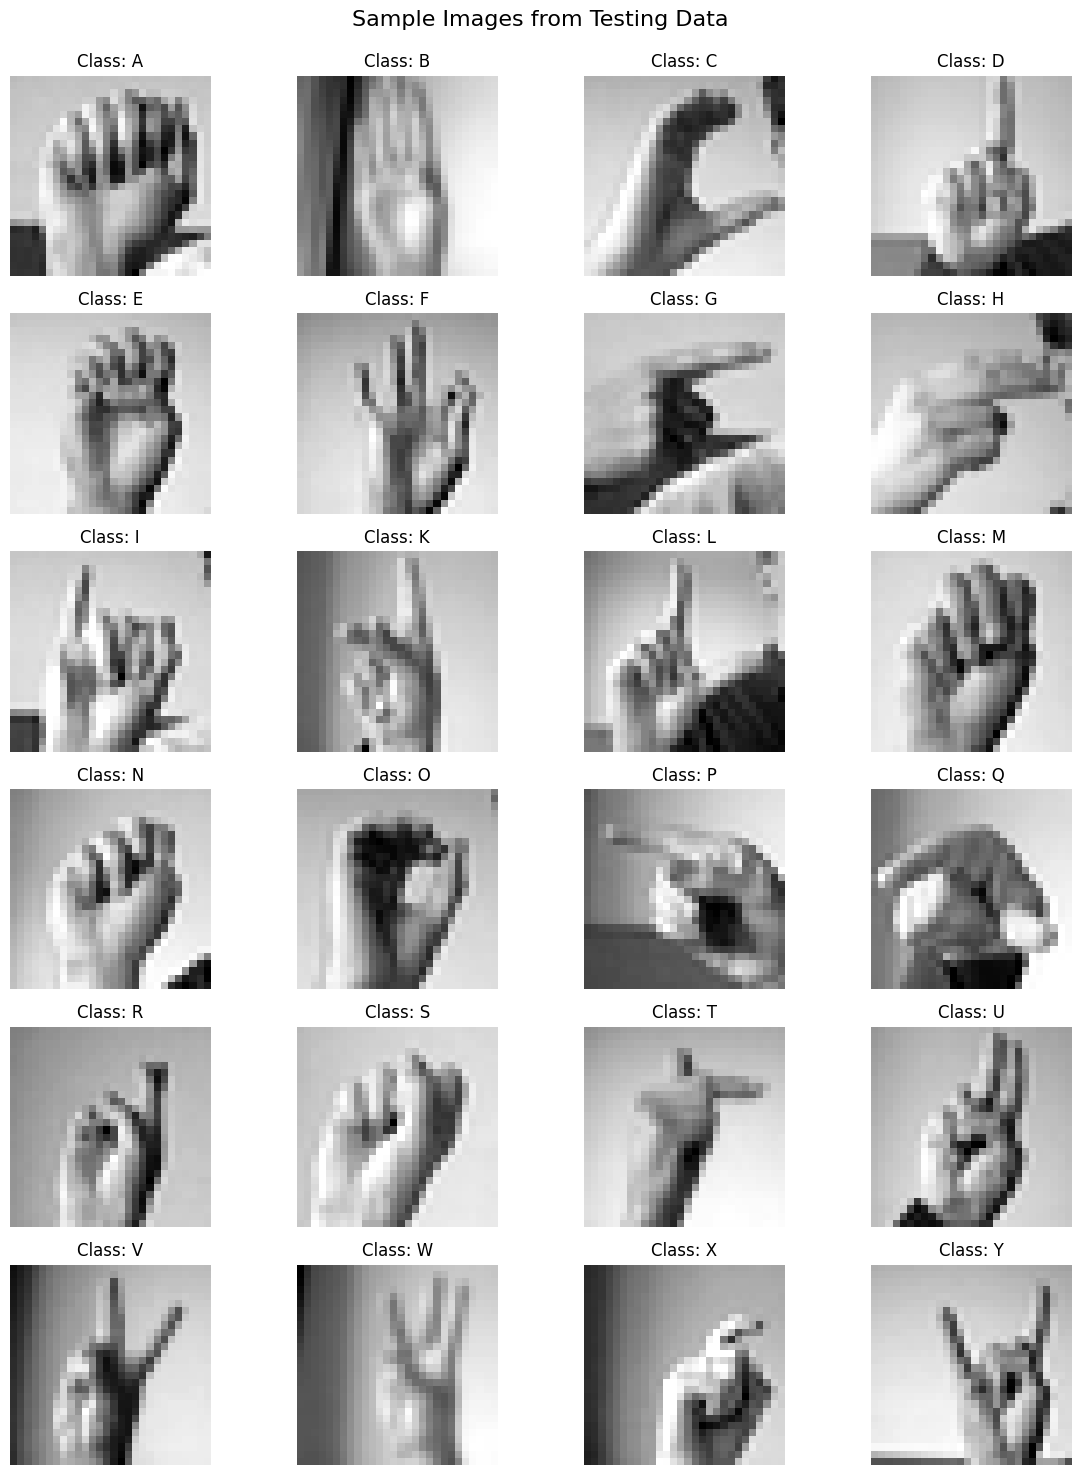

In [26]:
displaySampleImages(df_test, 'Sample Images from Testing Data\n')

In [27]:
def displyCOnfusionMatrix(cm, classes):

  plt.figure(figsize=(10, 10))
  sns.heatmap(cm, annot=True, fmt="d", cmap='viridis', xticklabels=classes, yticklabels=classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.savefig('confusion_matrix.png')

In [28]:
results = {}

In [29]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model__name, augment=False, epochs=5, batch_size=32):

    if augment:
        datagen = ImageDataGenerator(rotation_range=10, horizontal_flip=False, width_shift_range=0.1, height_shift_range=0.1, vertical_flip=False, zoom_range=0.1)
        datagen.fit(X_train.values.reshape(-1, 28, 28, 1))

        augmented_data = []
        augmented_labels = []

        for epoch in range(epochs):
            for X_batch, y_batch in datagen.flow(X_train.values.reshape(-1, 28, 28, 1), y_train, batch_size=batch_size):
                augmented_data.append(X_batch)
                augmented_labels.append(y_batch)

                if len(augmented_data) >= len(X_train):
                    break

        augmented_data = np.concatenate(augmented_data, axis=0)
        augmented_labels = np.concatenate(augmented_labels, axis=0)

        X_train_flattened = augmented_data.reshape(augmented_data.shape[0], 28 * 28)
    else:
        X_train_flattened = X_train

    if model__name != 'Sequential':
        model.fit(X_train_flattened, y_train)

    model_name = model.__class__.__name__

    if model__name != 'Sequential':
        y_pred = model.predict(X_test)

    else:
        y_pred = np.argmax(model.predict(X_test), axis=-1)

    print(f"\n\n\033[1;34mAccuracy\033[0m: \033[1;92m{accuracy_score(y_test, y_pred):.4f}\033[0m")
    print(f"\033[1;34mModel\033[0m: \033[1;92m{model_name}\033[0m\n")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    displyCOnfusionMatrix(confusion_matrix(y_test, y_pred), list(mapping.values()))


    if model_name not in results:
        results[model_name] = {'Accuracy': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0}

    results[model_name]['Accuracy'] = accuracy_score(y_test, y_pred)
    results[model_name]['Precision'] = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['precision']
    results[model_name]['Recall'] = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['recall']
    results[model_name]['F1-Score'] = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']

In [30]:
param_grid_logistic = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['saga'],
    'max_iter': [100, 200],
}

In [31]:
param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

In [32]:
param_grid_random_forest = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}

In [33]:
param_grid_perceptron = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000],
    'tol': [1e-3]
}

In [34]:
param_grid_mlp = {
    'hidden_layer_sizes': [(128,), (128, 64), (256, 128)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500]
}

In [35]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

In [36]:
def perform_grid_search(model, param_grid, X_train, y_train):

    print(f"\n\033[1;34mPerforming Grid Search for {model.__class__.__name__}...\033[0m")

    grid_search = GridSearchCV(model, param_grid, cv=3, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"\nBest parameters for {model.__class__.__name__}:\033[1;92m {grid_search.best_params_}\033[0m\n")

    print(f"\n\033[1;34mBest score for {model.__class__.__name__}:\033[0m \033[1;92m{grid_search.best_score_:.4f}\033[0m\n")

    return grid_search.best_estimator_

In [37]:
logistic_regression_model = perform_grid_search(LogisticRegression(verbose=1, n_jobs=-1), param_grid_logistic, X_train, y_train)


Performing Grid Search for LogisticRegression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 23 seconds

Best parameters for LogisticRegression: {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', 'solver': 'saga'}


Best score for LogisticRegression: 0.8925



In [38]:
decision_tree_model = perform_grid_search(DecisionTreeClassifier(random_state=42), param_grid_decision_tree, X_train, y_train)


Performing Grid Search for DecisionTreeClassifier...
Fitting 3 folds for each of 144 candidates, totalling 432 fits

Best parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


Best score for DecisionTreeClassifier: 0.9655



In [39]:
random_forest_model = perform_grid_search(RandomForestClassifier(random_state=42, verbose=1, n_jobs=-1), param_grid_random_forest, X_train, y_train)


Performing Grid Search for RandomForestClassifier...
Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s



Best parameters for RandomForestClassifier: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Best score for RandomForestClassifier: 1.0000



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.6s finished


In [40]:
perceptron_model = perform_grid_search(Perceptron(verbose=1, n_jobs=-1), param_grid_perceptron, X_train, y_train)


Performing Grid Search for Perceptron...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 17501.06, NNZs: 48, Bias: -12358.000000, T: 27455, Avg. loss: 344180.730985
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 18010.98, NNZs: 50, Bias: -12539.000000, T: 27455, Avg. loss: 357071.214613
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 17488.28, NNZs: 48, Bias: -12635.000000, T: 27455, Avg. loss: 355739.561454
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 16725.21, NNZs: 49, Bias: -12196.000000, T: 27455, Avg. loss: 335527.581794
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 33286.69, NNZs: 50, Bias: -24629.000000, T: 54910, Avg. loss: 328147.767889
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 34039.01, NNZs: 46, Bias: -24977.000000, T: 54910, Avg. loss: 340518.139176
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 33921.14, NNZs: 48, Bias: -25153.000000, T: 54910, Avg. loss: 339417.888909
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 31573.76, NNZs: 46, Bias: -24084.000000, T: 54910, Avg

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    6.8s finished


In [41]:
mlp_model = perform_grid_search(MLPClassifier(random_state=42, verbose=True, early_stopping=True), param_grid_mlp, X_train, y_train)


Performing Grid Search for MLPClassifier...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Iteration 1, loss = 4.94620690
Validation score: 0.952294
Iteration 2, loss = 0.26071879
Validation score: 0.975601
Iteration 3, loss = 0.12147041
Validation score: 0.991988
Iteration 4, loss = 0.09772851
Validation score: 0.991260
Iteration 5, loss = 0.06918542
Validation score: 0.991988
Iteration 6, loss = 0.03757448
Validation score: 0.996358
Iteration 7, loss = 0.02805050
Validation score: 0.996723
Iteration 8, loss = 0.04011825
Validation score: 0.994902
Iteration 9, loss = 0.03781229
Validation score: 0.999636
Iteration 10, loss = 0.00712823
Validation score: 0.997815
Iteration 11, loss = 0.00318421
Validation score: 0.996723
Iteration 12, loss = 0.00502886
Validation score: 0.998908
Iteration 13, loss = 0.00616139
Validation score: 0.999272
Iteration 14, loss = 0.00269004
Validation score: 0.998908
Iteration 15, loss = 0.00233594
Validation score: 0.999272
Iteration 16, los

In [42]:
svm_model = perform_grid_search(SVC(verbose=True), param_grid_svm, X_train, y_train)


Performing Grid Search for SVC...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LibSVM]
Best parameters for SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


Best score for SVC: 1.0000



In [43]:
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train.drop('label', axis=1).values).reshape(-1, 28, 28, 1)
X_test  = scaler.transform(df_test.drop('label', axis=1).values).reshape(-1, 28, 28, 1)

In [44]:
cnn_model = Sequential([
    Conv2D(filters=32 , kernel_size=(3, 3), activation='relu' , input_shape=(28, 28, 1)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), activation='tanh'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(64 , activation ="relu"),
    Dense(128, activation ="tanh"),
    Dense(128, activation ="tanh"),
    Dense(25 , activation ="softmax")
])

In [45]:
cnn_model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [46]:
stats = cnn_model.fit(X_train, y_train, batch_size=512, epochs=20, verbose=1, validation_split=0.1)

with open('cnn_model.pkl', 'wb') as file:
    pickle.dump(cnn_model, file)

Epoch 1/20
49/49 [==============================] - 34s 671ms/step - loss: 2.3573 - accuracy: 0.3374 - val_loss: 1.4289 - val_accuracy: 0.6078
Epoch 2/20
49/49 [==============================] - 32s 644ms/step - loss: 0.9400 - accuracy: 0.7554 - val_loss: 0.5840 - val_accuracy: 0.8704
Epoch 3/20
49/49 [==============================] - 30s 621ms/step - loss: 0.3990 - accuracy: 0.9204 - val_loss: 0.2506 - val_accuracy: 0.9701
Epoch 4/20
49/49 [==============================] - 30s 619ms/step - loss: 0.1725 - accuracy: 0.9797 - val_loss: 0.1044 - val_accuracy: 0.9949
Epoch 5/20
49/49 [==============================] - 30s 617ms/step - loss: 0.0719 - accuracy: 0.9973 - val_loss: 0.0575 - val_accuracy: 0.9964
Epoch 6/20
49/49 [==============================] - 30s 610ms/step - loss: 0.0364 - accuracy: 0.9994 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 7/20
49/49 [==============================] - 30s 617ms/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.0178 - val_accuracy: 1.0000

In [47]:
def plot_loss_accuracy(stats):

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(stats.history['loss'], label='Train Loss')
    ax[0].plot(stats.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss vs Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(stats.history['accuracy'], label='Train Accuracy')
    ax[1].plot(stats.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy vs Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()

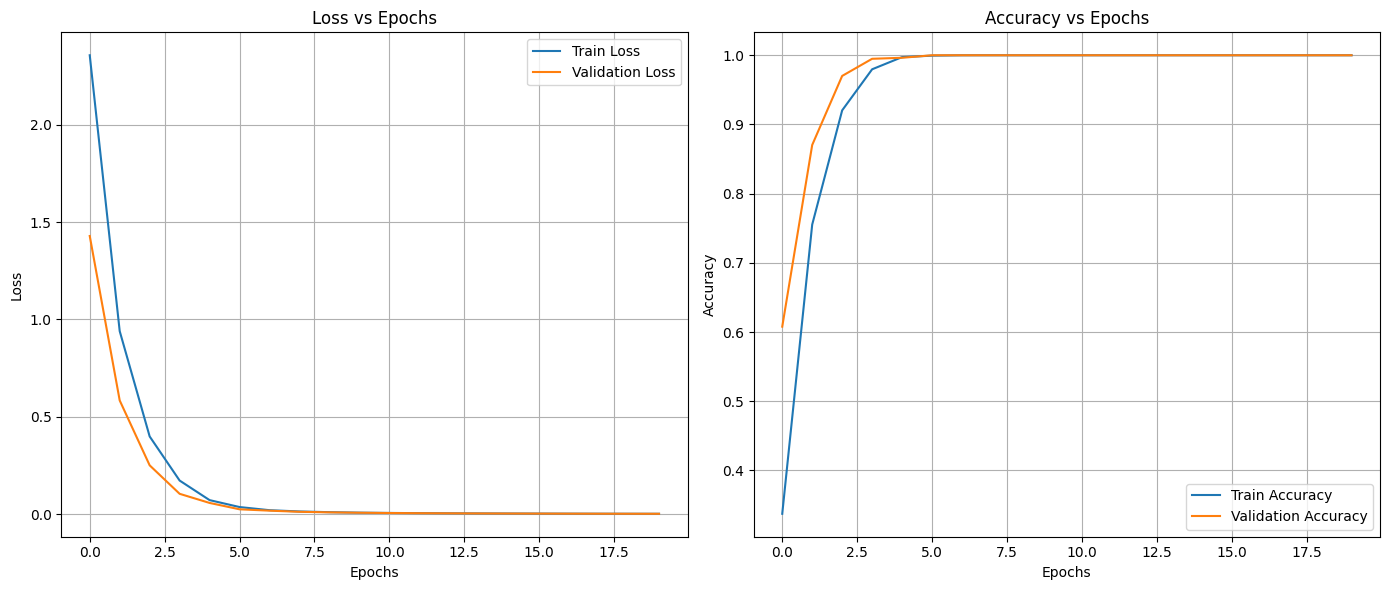

In [48]:
plot_loss_accuracy(stats)

In [49]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 256)         0

In [50]:
models = {
    'LogisticRegression': logistic_regression_model,
    'DecisionTreeClassifier': decision_tree_model,
    'RandomForestClassifier': random_forest_model,
    'Perceptron': perceptron_model,
    'MLPClassifier': mlp_model,
    'SVM': svm_model,
    'Sequential': cnn_model
}


Training LogisticRegression with best parameters...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 156 epochs took 255 seconds


Accuracy: 0.6718
Model: LogisticRegression


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90       331
           1       0.94      0.81      0.87       432
           2       0.94      0.95      0.95       310
           3       0.78      0.84      0.81       245
           4       0.83      0.87      0.85       498
           5       0.74      0.90      0.81       247
           6       0.74      0.68      0.71       348
           7       0.99      0.75      0.85       436
           8       0.69      0.65      0.67       288
          10       0.58      0.48      0.53       331
          11       0.75      0.93      0.83       209
          12       0.59      0.41      0.48       394
          13       0.61      0.55      0.58       291
          14       0.88      0.58      0.70       246
          15       0.91      0.93      0.92       347
          16      

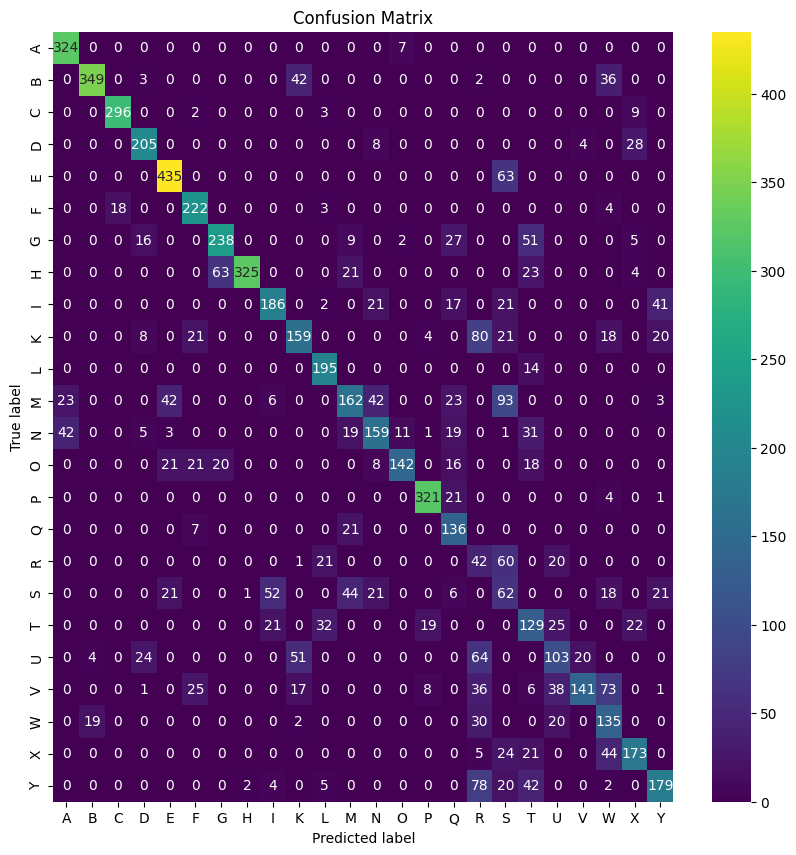


Training DecisionTreeClassifier with best parameters...



Accuracy: 0.4787
Model: DecisionTreeClassifier


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.85       331
           1       0.67      0.65      0.66       432
           2       0.80      0.83      0.81       310
           3       0.41      0.42      0.41       245
           4       0.76      0.61      0.67       498
           5       0.51      0.57      0.54       247
           6       0.45      0.45      0.45       348
           7       0.72      0.63      0.67       436
           8       0.28      0.27      0.27       288
          10       0.35      0.24      0.29       331
          11       0.35      0.55      0.43       209
          12       0.35      0.26      0.30       394
          13       0.33      0.33      0.33       291
          14       0.60      0.41      0.49       246
          15       0.72      0.60      0.65       347
  

<Figure size 640x480 with 0 Axes>

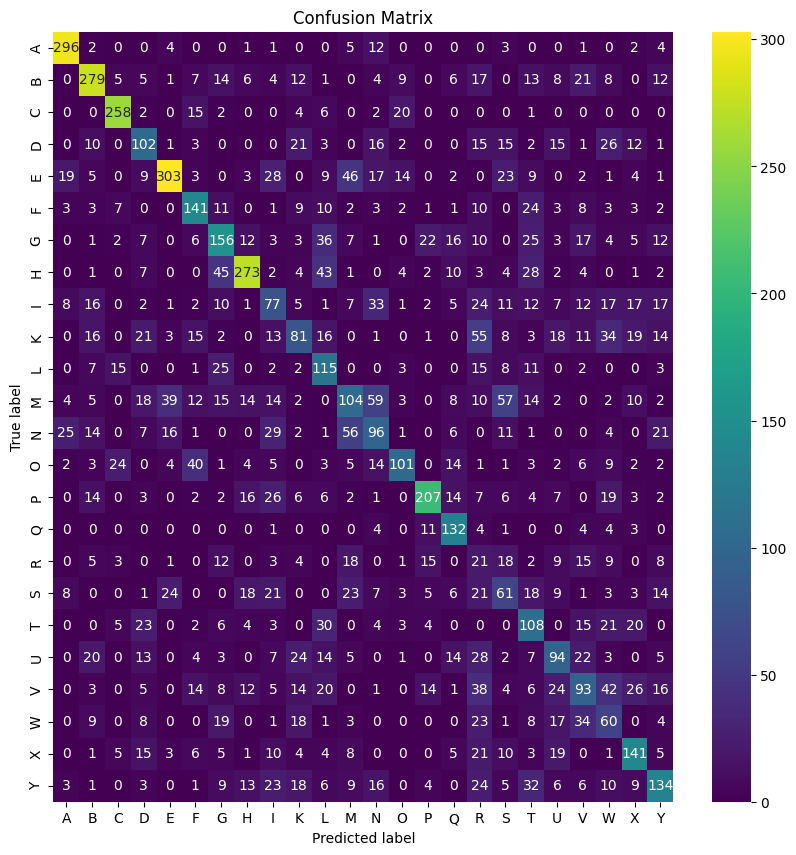


Training RandomForestClassifier with best parameters...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished




Accuracy: 0.8164
Model: RandomForestClassifier


Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       331
           1       0.98      0.93      0.95       432
           2       0.94      1.00      0.97       310
           3       0.83      0.98      0.90       245
           4       0.87      0.99      0.93       498
           5       0.93      0.91      0.92       247
           6       0.93      0.86      0.89       348
           7       0.99      0.94      0.96       436
           8       0.83      0.80      0.81       288
          10       0.72      0.64      0.68       331
          11       0.82      1.00      0.90       209
          12       0.88      0.71      0.78       394
          13       0.75      0.52      0.61       291
          14       0.99      0.88      0.93       246
          15       0.92      1.00      0.96       347
          16       0.91      0.99      0.95       164
      

<Figure size 640x480 with 0 Axes>

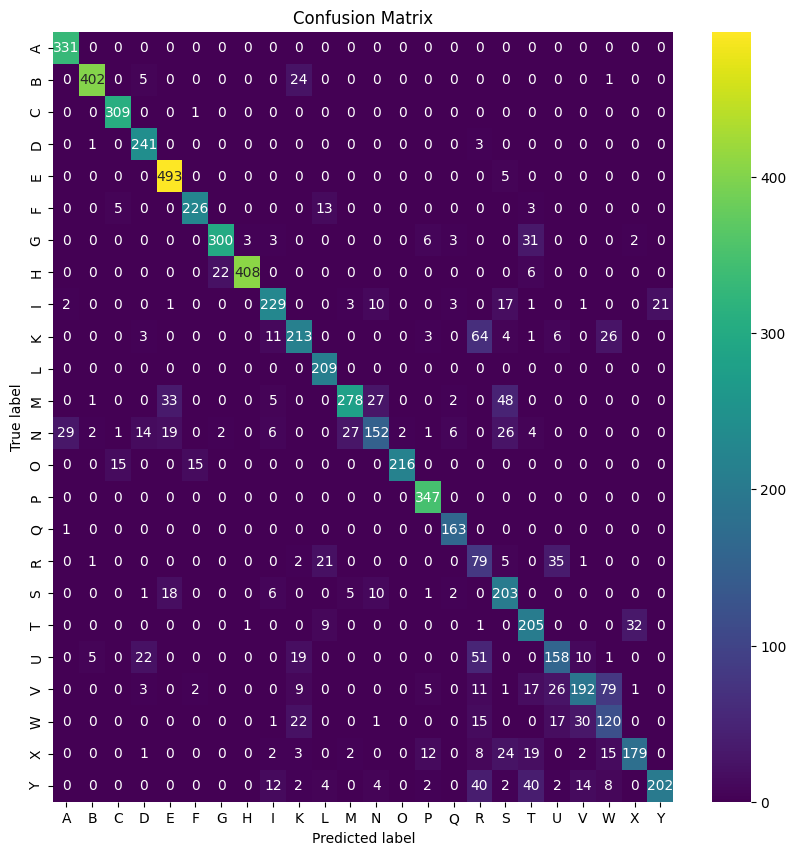


Training Perceptron with best parameters...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 555.54, NNZs: 53, Bias: -7.000000, T: 27455, Avg. loss: 0.904909
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 447.22, NNZs: 41, Bias: -8.000000, T: 27455, Avg. loss: 0.579084
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 574.11, NNZs: 62, Bias: -17.000000, T: 27455, Avg. loss: 1.100553
Total training time: 0.09 seconds.
-- Epoch 2
Norm: 661.85, NNZs: 115, Bias: -29.000000, T: 27455, Avg. loss: 2.650615
Total training time: 0.09 seconds.
-- Epoch 2
Norm: 791.79, NNZs: 42, Bias: -3.000000, T: 54910, Avg. loss: 0.201804
Total training time: 0.16 seconds.
-- Epoch 3
Norm: 645.11, NNZs: 28, Bias: -3.000000, T: 54910, Avg. loss: 0.079025
Total training time: 0.16 seconds.
-- Epoch 3
Norm: 819.65, NNZs: 48, Bias: -10.000000, T: 54910, Avg. loss: 0.254106
Total training time: 0.16 seconds.
-- Epoch 3
Norm: 965.23, NNZs: 89, Bias: -25.000000, T: 54910, Avg. loss: 0.765255
Total training time: 0.17 seconds.
-- Epoch 3
Norm: 979.46, N

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    9.0s finished



Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.41      0.58       331
           1       0.63      0.56      0.59       432
           2       0.55      0.80      0.66       310
           3       0.59      0.49      0.53       245
           4       1.00      0.02      0.04       498
           5       0.84      0.15      0.25       247
           6       1.00      0.09      0.16       348
           7       0.91      0.43      0.59       436
           8       0.39      0.05      0.08       288
          10       1.00      0.06      0.12       331
          11       0.93      0.53      0.67       209
          12       0.46      0.06      0.11       394
          13       0.71      0.18      0.28       291
          14       0.75      0.31      0.44       246
          15       0.95      0.21      0.34       347
          16       0.50      0.71      0.58       164
          17       0.04      0.85      0.07       144
  

<Figure size 640x480 with 0 Axes>

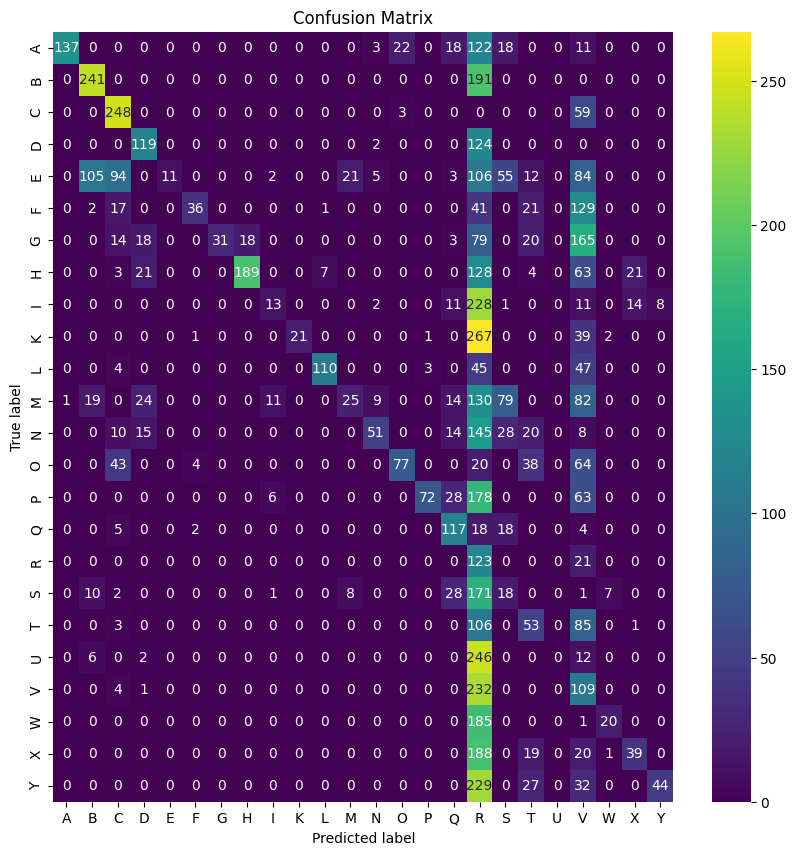


Training MLPClassifier with best parameters...

Iteration 1, loss = 3.14183221
Validation score: 0.149672
Iteration 2, loss = 2.98263954
Validation score: 0.215586
Iteration 3, loss = 2.84147250
Validation score: 0.302622
Iteration 4, loss = 2.69559540
Validation score: 0.360524
Iteration 5, loss = 2.54980468
Validation score: 0.395484
Iteration 6, loss = 2.40895652
Validation score: 0.438820
Iteration 7, loss = 2.27694533
Validation score: 0.465404
Iteration 8, loss = 2.15985047
Validation score: 0.490532
Iteration 9, loss = 2.05217449
Validation score: 0.524035
Iteration 10, loss = 1.95575682
Validation score: 0.530590
Iteration 11, loss = 1.86924657
Validation score: 0.559359
Iteration 12, loss = 1.79104316
Validation score: 0.566642
Iteration 13, loss = 1.72065673
Validation score: 0.576475
Iteration 14, loss = 1.65684986
Validation score: 0.595776
Iteration 15, loss = 1.59811420
Validation score: 0.612527
Iteration 16, loss = 1.54408991
Validation score: 0.609614
Iteration 17, lo

<Figure size 640x480 with 0 Axes>

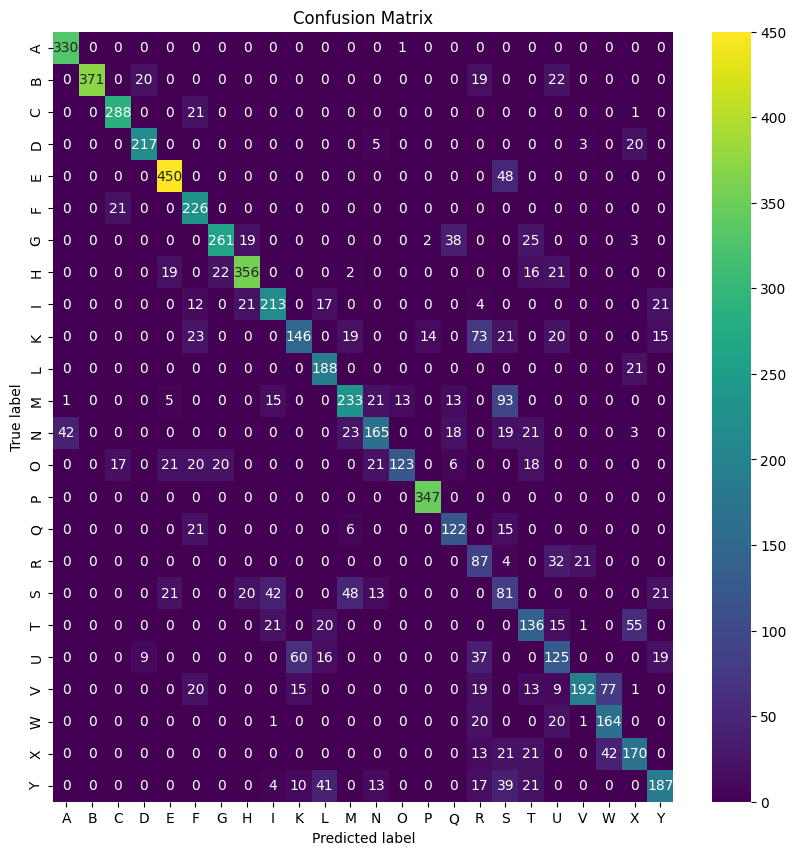


Training SVM with best parameters...

[LibSVM]

Accuracy: 0.7787
Model: SVC


Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94       331
           1       1.00      0.95      0.97       432
           2       0.78      0.99      0.87       310
           3       0.92      0.96      0.94       245
           4       0.93      1.00      0.96       498
           5       0.78      0.91      0.84       247
           6       0.82      0.89      0.85       348
           7       0.98      0.85      0.91       436
           8       0.70      0.75      0.72       288
          10       0.62      0.40      0.48       331
          11       0.68      0.81      0.74       209
          12       0.81      0.70      0.75       394
          13       0.84      0.63      0.72       291
          14       0.89      0.66      0.76       246
          15       0.89      1.00      0.94       347
          16       0.78      0.8

<Figure size 640x480 with 0 Axes>

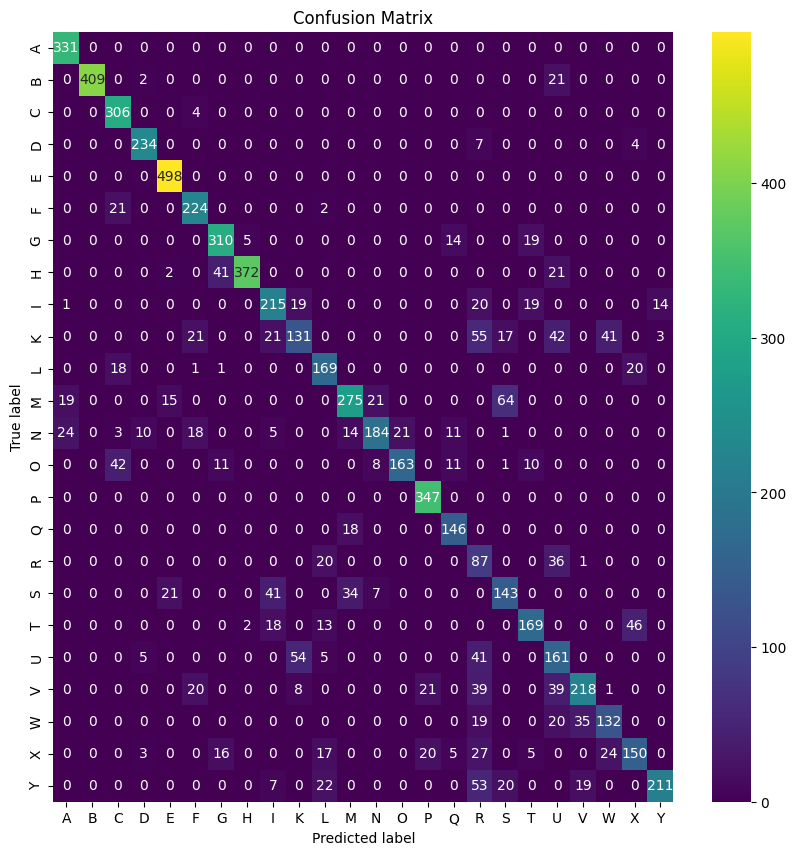


Training Sequential with best parameters...

225/225 [==============================] - 4s 16ms/step


Accuracy: 0.9320
Model: Sequential


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       331
           1       1.00      0.98      0.99       432
           2       0.95      1.00      0.97       310
           3       0.97      0.96      0.97       245
           4       0.98      0.96      0.97       498
           5       1.00      1.00      1.00       247
           6       0.90      0.90      0.90       348
           7       0.97      1.00      0.99       436
           8       0.86      0.85      0.86       288
          10       1.00      0.92      0.96       331
          11       0.92      1.00      0.96       209
          12       0.86      0.96      0.91       394
          13       1.00      0.85      0.92       291
          14       1.00      0.93      0.96       246
          15       1.00 

<Figure size 640x480 with 0 Axes>

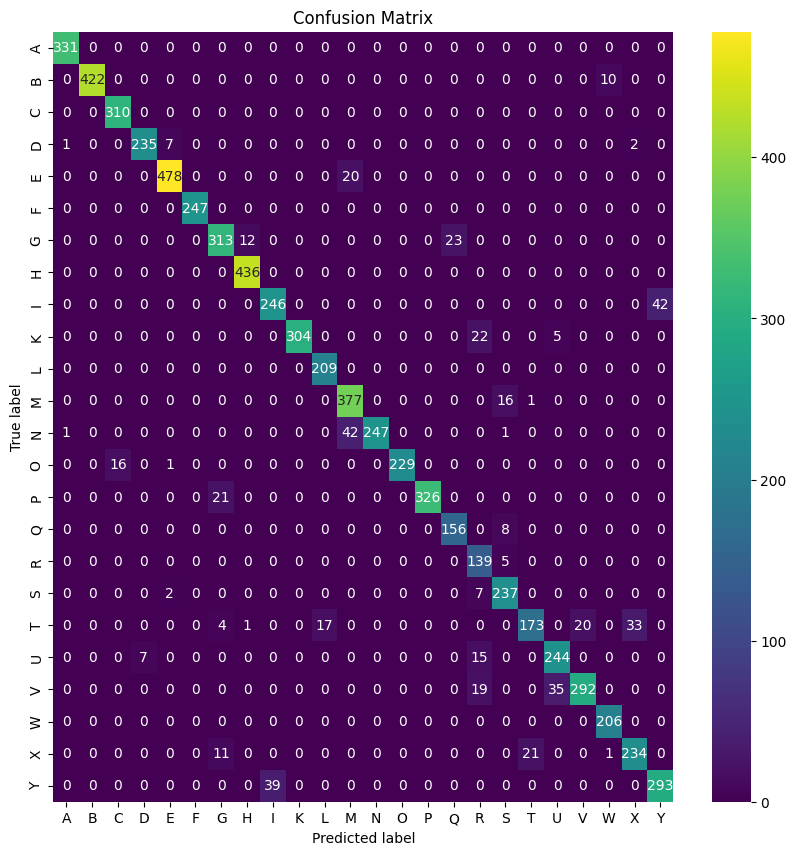

<Figure size 640x480 with 0 Axes>

In [51]:
for model_name, model in models.items():
    print(f"\n\033[1;34mTraining {model_name} with best parameters...\033[0m\n")
    train_and_evaluate_model(model, df_train.drop('label', axis=1) / 255.0 if model_name != 'Sequential' else X_train, y_train, df_test.drop('label', axis=1) / 255.0 if model_name != 'Sequential' else X_test, y_test, model_name)

In [52]:
table = [[model, *metrics.values()] for model, metrics in results.items()]
print(tabulate.tabulate(table, headers=["Model", "Accuracy", "Precision", "Recall", "F1-Score"], tablefmt="grid"))

+------------------------+------------+-------------+----------+------------+
| Model                  |   Accuracy |   Precision |   Recall |   F1-Score |
+========================+============+=============+==========+============+
| LogisticRegression     |   0.671779 |    0.712523 | 0.671779 |   0.680111 |
+------------------------+------------+-------------+----------+------------+
| DecisionTreeClassifier |   0.478667 |    0.498118 | 0.478667 |   0.483469 |
+------------------------+------------+-------------+----------+------------+
| RandomForestClassifier |   0.816369 |    0.832383 | 0.816369 |   0.817111 |
+------------------------+------------+-------------+----------+------------+
| Perceptron             |   0.265477 |    0.65127  | 0.265477 |   0.298552 |
+------------------------+------------+-------------+----------+------------+
| MLPClassifier          |   0.721974 |    0.746203 | 0.721974 |   0.724736 |
+------------------------+------------+-------------+----------+

In [53]:
def get_best_model(results):

    best_model_name = max(results, key=lambda x: results[x]['Accuracy'])
    print(f"\n\033[1;34mBest Model based on Accuracy:\033[0m \033[1;92m{best_model_name}\033[0m\n")

    return best_model_name

In [54]:
def preprocess_image(image_path, for_cnn=False):

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")

    img_resized = cv2.resize(img, (28, 28))
    img_normalized = img_resized / 255.0

    if for_cnn:
        return img_normalized.reshape(1, 28, 28, 1)
    else:
        return img_normalized.reshape(1, -1)

In [55]:
def predict_new_image(model, image_path, use_cnn=False):

    if use_cnn:
        preprocessed_image = preprocess_image(image_path, for_cnn=True)
        predicted_class = mapping.get(np.argmax(model.predict(preprocessed_image)), "Unknown")

    else:
        preprocessed_image = preprocess_image(image_path, for_cnn=False)
        predicted_class = mapping.get(model.predict(preprocessed_image)[0], "Unknown")

    plt.imshow(preprocessed_image.reshape(28, 28), cmap='gray')
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"\n\033[1;34mPredicted Class:\033[0m \033[1;92m{predicted_class}\033[0m\n")


Best Model based on Accuracy: Sequential

1/1 [==============================] - 0s 25ms/step


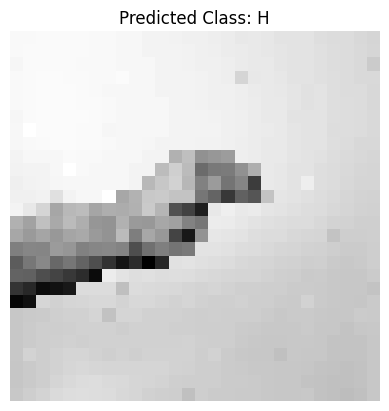


Predicted Class: H



In [56]:
predict_new_image(models[get_best_model(results)], 'H.jpg', True)